# Import Importance variable

In [3]:
import pandas as pd
import psycopg2
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy import stats
import neurokit2 as nk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Murat preprocessing

In [ ]:
# Load the CSV file into a DataFrame
merged_df_copy = pd.read_pickle('merged_df_copy.pkl')

In [ ]:
merged_df_copy.head()

In [ ]:
row_index = 0  # Specify the index of the row we want to analyze
selected_row = merged_df_copy.iloc[row_index]

# Iterate over each index and value in the selected row
for column_name, cell_value in selected_row.items():
    # Check if the cell value is a list
    if isinstance(cell_value, list):
        # Get the length of the list and print it
        list_size = len(cell_value)
        print(f"Size of list in column '{column_name}': {list_size}")



In [ ]:
merged_df_copy.iloc[2]

In [ ]:
merged_df_copy.head()

In [ ]:
# Function to interpolate each row separately for gaze data
def interpolate_row(row):
    row['Gaze_X'] = pd.Series(row['Gaze_X']).interpolate().values
    row['Gaze_Y'] = pd.Series(row['Gaze_Y']).interpolate().values
    row['Pupil_left'] = pd.Series(row['Pupil_left']).interpolate().values
    row['Pupil_right'] = pd.Series(row['Pupil_right']).interpolate().values
    return row

# Function to interpolate each row separately for ecg data
def interpolate_row_ecg(row):
    row['ecg_data'] = pd.Series(row['ecg_data']).interpolate().values
    row['Dates_sensor'] = row['Dates_sensor']
    return row

# Initialize empty lists to store the extracted data
extracted_data_1 = []
extracted_data_2 = []

# Iterate through each row in merged_df_copy
for index, (row_index, sample_row) in enumerate(merged_df_copy.iterrows(), 1):
    # Extract the relevant columns
    subject_id = sample_row["subject_id"]
    game_type = sample_row["game_type"]
    difficulty_levels = sample_row["Difficulty"]
    start_times = sample_row["Start_time_Dates"]
    end_times = sample_row["End_time_Dates"]
    pupil_left = sample_row["Pupil_left"]
    pupil_right = sample_row["Pupil_right"]
    ecg_data = sample_row["ecg_data"]
    gaze_x = sample_row["Gaze_X"]
    gaze_y = sample_row["Gaze_Y"]
    dates_eye = sample_row["Dates_eye"]
    dates_sensor = sample_row["Dates_sensor"]

    # Extract unique difficulty levels
    unique_difficulty_levels = set(difficulty_levels)

    # Iterate through each unique difficulty level
    for difficulty_level in unique_difficulty_levels:
        # Find the indices of rows corresponding to the current difficulty level
        indices = [i for i, level in enumerate(difficulty_levels) if level == difficulty_level]

        # Check if there are any rows with this difficulty level
        if not indices:
            continue

        # Find the first occurrence (start time) for this difficulty level
        first_start_time = None
        try:
            if start_times:
                first_start_time = min([pd.to_datetime(start_times[i], errors='coerce') for i in indices if i < len(start_times)])
        except ValueError as e:
            print(f"Error parsing start time for difficulty level {difficulty_level}: {e}")
            continue

        # Find the last occurrence (end time) for this difficulty level
        last_end_time = None
        try:
            if end_times and any(i < len(end_times) for i in indices):
                last_end_time = max([pd.to_datetime(end_times[i], errors='coerce') for i in indices if i < len(end_times)])
        except ValueError as e:
            print(f"Error parsing end time for difficulty level {difficulty_level}: {e}")
            continue

        # Ensure start and end times are not None before proceeding
        if first_start_time is None or last_end_time is None:
            continue

        # Find the indices within the date range
        date_range_indices_eye = [i for i, date in enumerate(dates_eye) if first_start_time <= date <= last_end_time]
        date_range_indices_sensor = [i for i, date in enumerate(dates_sensor) if first_start_time <= date <= last_end_time]

        # Aggregate the data into dictionaries
        aggregated_data_1 = {
            "subject_id": subject_id,
            "game_type": game_type,
            "Difficulty": difficulty_level,
            "Start_time": first_start_time,
            "End_time": last_end_time,
            "Gaze_X": [gaze_x[i] for i in date_range_indices_eye],
            "Gaze_Y": [gaze_y[i] for i in date_range_indices_eye],
            "Dates_eye": [dates_eye[i] for i in date_range_indices_eye],
            "Pupil_left": [pupil_left[i] for i in date_range_indices_eye],
            "Pupil_right": [pupil_right[i] for i in date_range_indices_eye]
        }

        aggregated_data_2 = {
            "subject_id": subject_id,
            "game_type": game_type,
            "Difficulty": difficulty_level,
            "Start_time": first_start_time,
            "End_time": last_end_time,
            "Dates_sensor": [dates_sensor[i] for i in date_range_indices_sensor],
            "ecg_data": [ecg_data[i] for i in date_range_indices_sensor]
        }


        # Append the aggregated data to the respective lists
        extracted_data_1.append(aggregated_data_1)
        extracted_data_2.append(aggregated_data_2)
            
        print(f"Processed chunk {index}/{len(merged_df_copy)}")

# Convert the lists of dictionaries into DataFrames
all_extracted_data_1 = pd.DataFrame(extracted_data_1)
all_extracted_data_2 = pd.DataFrame(extracted_data_2)

# Interpolate each row separately
all_extracted_data_1 = all_extracted_data_1.apply(interpolate_row, axis=1)
all_extracted_data_2 = all_extracted_data_2.apply(interpolate_row_ecg, axis=1)

# Merge the interpolated dataframes
combined_data = pd.merge(all_extracted_data_1, all_extracted_data_2, on=["subject_id", "game_type", "Difficulty", "Start_time", "End_time"])

combined_data.head()


In [ ]:
combined_data['Pupil_right']

In [ ]:
# Calculate missing ratio for Pupil_right
combined_data['Pupil_right_missing_ratio'] = combined_data['Pupil_right'].apply(lambda x: pd.Series(x).isnull().mean())

# Display the DataFrame with the new column
combined_data

In [ ]:
# Find the row index with the maximum missing ratio for Pupil_right
max_missing_ratio_index = combined_data['Pupil_right_missing_ratio'].idxmax()

# Get the row with the maximum missing ratio
row_with_max_missing_ratio = combined_data.loc[max_missing_ratio_index]

# Display the row
row_with_max_missing_ratio


In [ ]:
print(row_with_max_missing_ratio['Pupil_right'])


In [ ]:
import matplotlib.pyplot as plt

# Find the row with the maximum missing ratio for Pupil_right
max_missing_ratio_index = combined_data['Pupil_right_missing_ratio'].idxmax()
row_with_max_missing_ratio = combined_data.loc[max_missing_ratio_index]

# Plot the missing values ratio for Pupil_right as a line plot
plt.figure(figsize=(10, 6))
plt.plot(row_with_max_missing_ratio['Pupil_right'], linestyle='-')
plt.title('Missing Values Ratio for Pupil_right')
plt.xlabel('Index')
plt.ylabel('Missing Values Ratio')
plt.grid(True)
plt.show()


In [ ]:
combined_data["game_type"].unique()

In [ ]:
# Choose a random row index
random_row_index = random.randint(0, len(combined_data) - 1)

# Select the random row
random_row = combined_data.iloc[random_row_index]

# Extract the time-series data for plotting
gaze_x = random_row['Gaze_X']
gaze_y = random_row['Gaze_Y']
pupil_left = random_row['Pupil_left']
pupil_right = random_row['Pupil_right']
ecg_data = random_row['ecg_data'][:10000]  # Extract first 1000 values
Dates_eye = random_row['Dates_eye']
Dates_sensor = random_row['Dates_sensor'][:10000]  # Extract first 1000 values
game_type = random_row['game_type']  # Extract game_type

# Plotting
plt.figure(figsize=(12, 10))  # Increase the figure size to accommodate the larger subplot

plt.suptitle(f'Game Type: {game_type}', fontsize=16)  # Set the title for the entire figure

plt.subplot(3, 2, (5, 6))  # Combine the last two subplots into one
plt.plot(Dates_sensor, ecg_data)
plt.title('ECG Data (First 10000 Values)')

plt.subplot(3, 2, 1)
plt.plot(Dates_eye, gaze_x)
plt.title('Gaze_X')

plt.subplot(3, 2, 2)
plt.plot(Dates_eye, gaze_y)
plt.title('Gaze_Y')

plt.subplot(3, 2, 3)
plt.plot(Dates_eye, pupil_left)
plt.title('Pupil_left')

plt.subplot(3, 2, 4)
plt.plot(Dates_eye, pupil_right)
plt.title('Pupil_right')

plt.tight_layout()
plt.show()


In [ ]:
Dates_eye

In [ ]:
from scipy.stats import zscore

# Define a custom function to calculate z-scores while preserving NaN values within each list
def calculate_zscores_with_nan(lst):
    # Convert the list to a NumPy array
    np_array = np.array(lst)
    
    # Check if the array contains any non-numeric values
    if np.issubdtype(np_array.dtype, np.number):
        # Calculate the z-scores while preserving NaN values
        zscores = zscore(np_array, nan_policy='omit')
        return zscores.tolist()
    else:
        # If the array contains non-numeric values, return the original list
        return lst


# Create a new DataFrame 'combined_data_zscore' by applying the custom function to the specified columns
combined_data_zscore = combined_data.copy()  # Make a copy of the original DataFrame

# Apply the custom function to calculate z-scores (preserving NaN values within each list)
combined_data_zscore['Gaze_X'] = combined_data_zscore['Gaze_X'].apply(calculate_zscores_with_nan)
combined_data_zscore['Gaze_Y'] = combined_data_zscore['Gaze_Y'].apply(calculate_zscores_with_nan)
combined_data_zscore['Pupil_left'] = combined_data_zscore['Pupil_left'].apply(calculate_zscores_with_nan)
combined_data_zscore['Pupil_right'] = combined_data_zscore['Pupil_right'].apply(calculate_zscores_with_nan)
combined_data_zscore['ecg_data'] = combined_data_zscore['ecg_data'].apply(calculate_zscores_with_nan)

In [ ]:
# Select the random row
random_row = combined_data_zscore.iloc[random_row_index]

# Choose a random row index
random_row_index = random.randint(0, len(combined_data) - 1)

# Extract the time-series data for plotting
gaze_x = random_row['Gaze_X']
gaze_y = random_row['Gaze_Y']
pupil_left = random_row['Pupil_left']
pupil_right = random_row['Pupil_right']
ecg_data = random_row['ecg_data']  # Extract first 1000 values
Dates_eye = random_row['Dates_eye']
Dates_sensor = random_row['Dates_sensor']

# Plotting
plt.figure(figsize=(12, 10))  # Increase the figure size to accommodate the larger subplot

plt.subplot(3, 2, (5, 6))  # Combine the last two subplots into one
plt.plot(Dates_sensor[:10000], ecg_data[:10000])
plt.title('ECG Data (First 10000 Values)')

plt.subplot(3, 2, 1)
plt.plot(Dates_eye, gaze_x)
plt.title('Gaze_X')

plt.subplot(3, 2, 2)
plt.plot(Dates_eye, gaze_y)
plt.title('Gaze_Y')

plt.subplot(3, 2, 3)
plt.plot(Dates_eye, pupil_left)
plt.title('Pupil_left')

plt.subplot(3, 2, 4)
plt.plot(Dates_eye, pupil_right)
plt.title('Pupil_right')

plt.tight_layout()
plt.show()


In [ ]:
combined_data_zscore['Gaze_X']

In [ ]:
combined_data['Difficulty']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Difficulty' column
combined_data_zscore['Difficulty_encoded'] = label_encoder.fit_transform(combined_data_zscore['Difficulty'])

# Display the mapping of encoded labels to original labels
print("Encoded labels:", label_encoder.classes_)

# Display the encoded 'Difficulty' column
print(combined_data_zscore['Difficulty_encoded'])


# Quang Code start here

In [ ]:
del merged_df_copy

In [ ]:
#Incorrect start_time in a row, overwrite it
ROW = ((combined_data_zscore['End_time'] - combined_data_zscore['Start_time']) / pd.Timedelta('1s')) > 2000  #filter row longer than 2000 second
combined_data_zscore.loc[ROW,'Start_time'] = combined_data_zscore.loc[ROW,'Dates_sensor'].tolist()[0][0]

In [ ]:
SUBJECT_ID = combined_data_zscore['subject_id'].unique()
TRAINING_ID = SUBJECT_ID[:int(len(SUBJECT_ID)*0.8)]
TESTING_ID = SUBJECT_ID[int(len(SUBJECT_ID)*0.8):]
GAME_TYPE = combined_data_zscore['game_type'].unique()
DIFF_ENCODING = {'Easy': 0, 'Medium': 1, 'Hard': 2}

print('SIZE:',len(TRAINING_ID), '  ',TRAINING_ID)
print('SIZE:',len(TESTING_ID), '  ',TESTING_ID)
print()
print('GAME_TYPE: ', GAME_TYPE)
print('Difficulty: ', combined_data_zscore['Difficulty'].unique())

In [ ]:
FS = 250 #Hz
CUTOFF_SNR = 4
CUTOFF_HR_MIN = 20
CUTOFF_HR_MAX = 250
BLOCK_DURATION = (combined_data_zscore['End_time'] - combined_data_zscore['Start_time']) / pd.Timedelta('1s') #in second
BLOCK_DURATION.describe()

In [ ]:
SAMPLES_DURATION = 25 #duration for each samples

In [ ]:
#over write difficulty encoding
combined_data_zscore['Difficulty_encoded'] = combined_data_zscore['Difficulty'].map(DIFF_ENCODING)


In [ ]:
combined_data_zscore

## Generating X, Y, I

In [ ]:
#calculate ECG data function

def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    array
        Array of ECG features: [mean heart rate, maximum heart rate, minimum heart rate, heart rate variability].
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) == 0:
        raise ValueError("No R-peaks detected in ECG signal.")
    if len(rr_times) < 3:
        raise ValueError("Detecting too few R-peaks.")    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if heart_rate.size == 0:
        raise ValueError("Error computing heart rate from ECG signal.")
    
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))

    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 2.0

    # Remove outliers from the valid_heart_rate array
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    d_rr_ms = 1000 * d_rr
    d_d_rr_ms = np.diff(d_rr_ms)

    valid_d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(valid_d_d_rr_ms))
    d_d_rr_ms= valid_d_d_rr_ms[z_scores <= z_score_threshold]
    heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
    
    if np.isnan(heart_rate_variability):
        raise ValueError("Unable to detect heart_rate_variability")    
    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.1 # 1 second before the RR interval
        end_time = rr_interval + 0.1   # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

     # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)
    
    return hr_mean, hr_max, hr_min, heart_rate_variability, snr_values

In [ ]:
def generate_X_Y_I_samples(data_df,SUBJECT_ID_LIST):
    X = []
    Y = []
    I = []
    for index ,current_row in data_df[data_df['subject_id'].isin(SUBJECT_ID_LIST)].iterrows():  
        #print(index)
        current_sid = current_row['subject_id']
        current_game_type = current_row['game_type']
        current_diff = current_row['Difficulty']

        #GET EYE_DF
        eye_data = {
            'Gaze_X': current_row['Gaze_X'],
            'Gaze_Y': current_row['Gaze_Y'],
            'Pupil_left': current_row['Pupil_left'],
            'Pupil_right': current_row['Pupil_right'],
            'time': current_row['Dates_eye']
        }
        temp_eye_df = pd.DataFrame(eye_data)

        #GET ECG_DF
        ecg_data = {
            'ecg_data': current_row['ecg_data'],
            'time': current_row['Dates_sensor'],
        }
        temp_ecg_df = pd.DataFrame(ecg_data)
    
        #missing_data check
        if temp_eye_df.shape[0] == 0 or temp_ecg_df.shape[0] == 0:
            print("SKIPPING: ", (current_row['subject_id'],current_row['game_type'],current_row['Difficulty']))
            continue
        
        #calculate start time
        duration = (temp_eye_df['time'].iloc[-1] - temp_eye_df['time'].iloc[0])/pd.Timedelta('1s')
        second_delta = duration % SAMPLES_DURATION / 2 #try to start at the middle of timeline
        
        start_time = temp_eye_df['time'].iloc[0] + pd.Timedelta(seconds=(second_delta))
        end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)
        stop_time = temp_eye_df['time'].iloc[-1]
    
        #generating each samples
        while end_time < stop_time:
            #append X
            temp_eye_df_2 = temp_eye_df.query('time > @start_time and time < @end_time').copy()
            temp_ecg_df_2 = temp_ecg_df.query('time > @start_time and time < @end_time').copy()
            temp_ecg_df_2['time_in_second'] = (temp_ecg_df_2['time'] - temp_ecg_df_2['time'].iloc[0]) / pd.Timedelta('1s')
            temp_ecg_df_2 = temp_ecg_df_2.reset_index() #need to reset index
            
            #NULL value check
            if temp_eye_df_2.isna().sum().sum() > 0 or temp_ecg_df_2.isna().sum().sum() > 0:
                print("SKIP NA: ", (current_sid,current_game_type,current_diff), "   ",
                      temp_eye_df_2.isna().sum().sum(), "   ", temp_ecg_df_2.isna().sum().sum())
                #update loop
                start_time = end_time
                end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)
                continue
                
            if temp_eye_df_2.shape[0] <= SAMPLES_DURATION * 50 or temp_ecg_df_2.shape[0] < SAMPLES_DURATION * 250:
                print("Invalid shape: ", (current_sid,current_game_type,current_diff), "   ",
                      temp_eye_df_2.shape, "   ", temp_ecg_df_2.shape)
                #update loop
                start_time = end_time
                end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)
                continue
                
            #Heart_rate calculate
            try:
                hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(
                    temp_ecg_df_2['ecg_data'],temp_ecg_df_2['time_in_second'],FS)
            except ValueError as e:
                print("Error while computer heart rate")
                #update loop
                start_time = end_time
                end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)
                continue
    
            #check for cutoff heart_rate
            if snr_values < CUTOFF_SNR or hr_min < CUTOFF_HR_MIN or hr_max > CUTOFF_HR_MAX:
                print("INVALID heart_rate:", snr_values, hr_min, hr_max)
                #update loop
                start_time = end_time
                end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)
                continue
            
            #calculate velocity
            time_diff = temp_eye_df_2['time'].diff().dt.total_seconds()
            temp_eye_df_2['Gaze_X_velocity'] = temp_eye_df_2['Gaze_X'].diff() / time_diff
            temp_eye_df_2['Gaze_Y_velocity'] = temp_eye_df_2['Gaze_Y'].diff() / time_diff
            temp_eye_df_2['Pupil_left_velocity'] = temp_eye_df_2['Pupil_left'].diff() / time_diff
            temp_eye_df_2['Pupil_right_velocity'] = temp_eye_df_2['Pupil_right'].diff() / time_diff
            stat_df = temp_eye_df_2.describe()
            #extract data
            pl_25 = stat_df.loc['25%','Pupil_left']
            pl_50 = stat_df.loc['50%','Pupil_left']
            pl_75 = stat_df.loc['75%','Pupil_left']
            pl_std= stat_df.loc['std','Pupil_left']
            
            pr_25 = stat_df.loc['25%','Pupil_right']
            pr_50 = stat_df.loc['50%','Pupil_right']
            pr_75 = stat_df.loc['75%','Pupil_right']
            pr_std= stat_df.loc['std','Pupil_right']
            
            pl_vec_50 = stat_df.loc['50%','Pupil_left_velocity']
            pl_vec_std= stat_df.loc['std','Pupil_left_velocity']
            
            pr_vec_50 = stat_df.loc['50%','Pupil_right_velocity']
            pr_vec_std= stat_df.loc['std','Pupil_right_velocity']
            
            gaze_x_vec_50 = stat_df.loc['50%','Gaze_X_velocity']
            gaze_x_vec_std= stat_df.loc['std','Gaze_X_velocity']
            
            gaze_y_vec_50 = stat_df.loc['50%','Gaze_Y_velocity']
            gaze_y_vec_std= stat_df.loc['std','Gaze_Y_velocity']
            
            
            if(np.isnan(pl_vec_std)):
                print("Invalid velocity")
                #update loop
                start_time = end_time
                end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)
                continue
    
            X.append([pl_25,pl_50,pl_75,pl_std,pr_25,pr_50,pr_75,pr_std,pl_vec_50,pl_vec_std,pr_vec_50,pr_vec_std,
                    gaze_x_vec_50,gaze_x_vec_std,gaze_y_vec_50,gaze_y_vec_std,hr_min,hr_mean,hr_max,heart_rate_variability])
            
            #append Y
            Y.append(DIFF_ENCODING[current_diff])
            #append I
            I.append((current_sid,current_game_type,current_diff))
            start_time = end_time
            end_time = start_time + pd.Timedelta(seconds=SAMPLES_DURATION)

        #end while loop
    #end for loop
    X = np.array(X)
    Y = np.array(Y)
    I = np.array(I)

    return X,Y,I
    

In [ ]:
X_final, Y_final, I_final = generate_X_Y_I_samples(combined_data_zscore,TRAINING_ID)

In [ ]:
X_test, Y_test, I_test = generate_X_Y_I_samples(combined_data_zscore,TESTING_ID)

In [ ]:
#spliting
X_train, X_val, Y_train, Y_val, I_train, I_val = train_test_split(X_final, Y_final, I_final, test_size=0.2, random_state=96)


In [ ]:
print(X_final.shape)
print(Y_final.shape)
print(I_final.shape)
print()
print(X_train.shape)
print(Y_train.shape)
print(I_train.shape)
print()
print(X_val.shape)
print(Y_val.shape)
print(I_val.shape)
print()
print(X_test.shape)
print(Y_test.shape)
print(I_test.shape)

**Counting percentage**

In [122]:
def counting_percentage(data):
    unique_game_types, counts = np.unique(data, return_counts=True)

    # Calculate percentages
    total_elements = len(data)
    percentages = (counts / total_elements) * 100


    # Display the results
    print("Total element: ", total_elements)
    for game_type, count, percentage in zip(unique_game_types, counts, percentages):
        print(f"{game_type:},   count: {count}, percent: {percentage:.2f}%")




In [123]:
print("Final:")
print("Game_type")
counting_percentage(I_final[:,1])

print()
print("Difficulty")
counting_percentage(I_final[:,2])



print("\n\nTraining_set:")
print("Game_type")
counting_percentage(I_train[:,1])

print()
print("Difficulty")
counting_percentage(I_train[:,2])



print("\n\nValidation:")
print("Game_type")
counting_percentage(I_val[:,1])

print()
print("Difficulty")
counting_percentage(I_val[:,2])



print("\n\nTest_set:")
print("Game_type")
counting_percentage(I_test[:,1])

print()
print("Difficulty")
counting_percentage(I_test[:,2])

Final:
Game_type
Total element:  3919
enumeration,   count: 758, percent: 19.34%
task switch,   count: 1231, percent: 31.41%
working memory,   count: 1930, percent: 49.25%

Difficulty
Total element:  3919
Easy,   count: 1060, percent: 27.05%
Hard,   count: 1588, percent: 40.52%
Medium,   count: 1271, percent: 32.43%


Training_set:
Game_type
Total element:  3135
enumeration,   count: 609, percent: 19.43%
task switch,   count: 979, percent: 31.23%
working memory,   count: 1547, percent: 49.35%

Difficulty
Total element:  3135
Easy,   count: 821, percent: 26.19%
Hard,   count: 1268, percent: 40.45%
Medium,   count: 1046, percent: 33.37%


Validation:
Game_type
Total element:  784
enumeration,   count: 149, percent: 19.01%
task switch,   count: 252, percent: 32.14%
working memory,   count: 383, percent: 48.85%

Difficulty
Total element:  784
Easy,   count: 239, percent: 30.48%
Hard,   count: 320, percent: 40.82%
Medium,   count: 225, percent: 28.70%


Test_set:
Game_type
Total element:  9

## Random Forest Model

In [129]:
# Create a random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(X_final, Y_final)

# Predict on validation set
Y_test_pred = random_forest.predict(X_test)

In [130]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='macro')
recall = recall_score(Y_test, Y_test_pred, average='macro')
f1 = f1_score(Y_test, Y_test_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.40923076923076923
Precision: 0.39351448128695976
Recall: 0.38281896558989353
F1 Score: 0.371061500620214


Feature ranking:
1. Feature 13: 0.055258541076192366
2. Feature 11: 0.05511682890036021
3. Feature 6: 0.05299396300076313
4. Feature 2: 0.05291055899650151
5. Feature 14: 0.05281054983959351
6. Feature 8: 0.052464078315929315
7. Feature 15: 0.05186468690500551
8. Feature 12: 0.0512665201710509
9. Feature 3: 0.05122820884801657
10. Feature 7: 0.0507644920733733
11. Feature 10: 0.050693935427571356
12. Feature 9: 0.0505748236116702
13. Feature 0: 0.04910242281737853
14. Feature 4: 0.049091319855900234
15. Feature 19: 0.048363755531482325
16. Feature 1: 0.046684352977074614
17. Feature 5: 0.04663028990731097
18. Feature 17: 0.044637991190848825
19. Feature 16: 0.04399677870343178
20. Feature 18: 0.043545901850544605


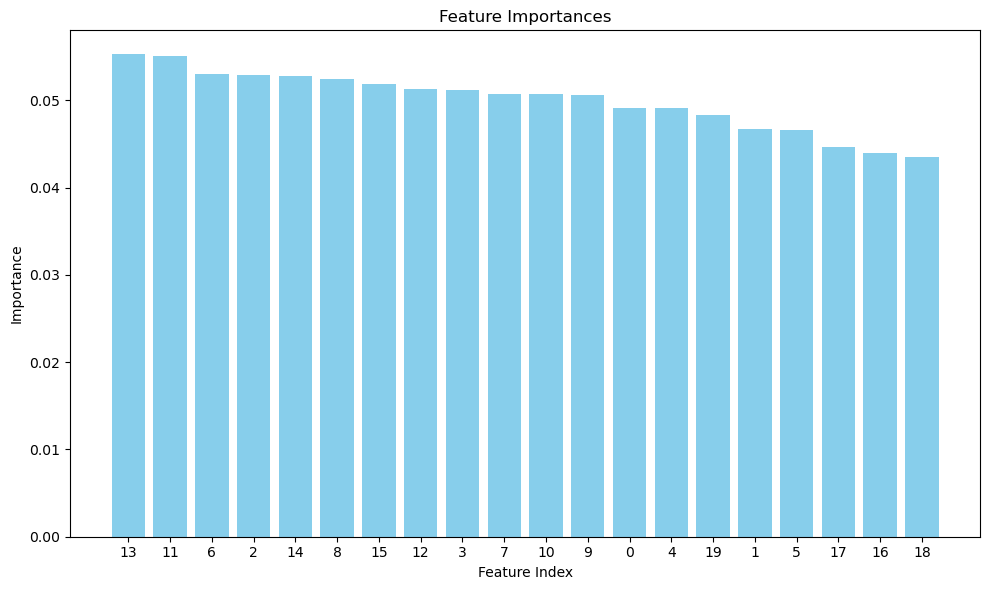

In [134]:
# Get feature importances
importances = random_forest.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {indices[f]}: {importances[indices[f]]}")

    
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## Deep learning

In [136]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=32)

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 4.5403 - accuracy: 0.3320 - val_loss: 2.2875 - val_accuracy: 0.3546
Epoch 2/100
98/98 [==============================] - 0s 2ms/step - loss: 2.1684 - accuracy: 0.3518 - val_loss: 1.8564 - val_accuracy: 0.3929
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 1.6209 - accuracy: 0.3781 - val_loss: 1.9764 - val_accuracy: 0.2946
Epoch 4/100
98/98 [==============================] - 0s 2ms/step - loss: 1.6763 - accuracy: 0.3683 - val_loss: 2.0303 - val_accuracy: 0.2857
Epoch 5/100
98/98 [==============================] - 0s 2ms/step - loss: 1.8032 - accuracy: 0.3649 - val_loss: 1.6527 - val_accuracy: 0.3763
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 1.4595 - accuracy: 0.3799 - val_loss: 1.6105 - val_accuracy: 0.3967
Epoch 7/100
98/98 [==============================] - 0s 2ms/step - loss: 1.4084 - accuracy: 0.4058 - val_loss: 1.5200 - val_accuracy: 0.2972
Epoch 8/100
9

Epoch 59/100
98/98 [==============================] - 0s 2ms/step - loss: 1.0631 - accuracy: 0.4402 - val_loss: 1.3671 - val_accuracy: 0.4235
Epoch 60/100
98/98 [==============================] - 0s 2ms/step - loss: 1.1123 - accuracy: 0.4346 - val_loss: 1.5003 - val_accuracy: 0.3827
Epoch 61/100
98/98 [==============================] - 0s 2ms/step - loss: 1.2062 - accuracy: 0.4306 - val_loss: 1.5075 - val_accuracy: 0.4043
Epoch 62/100
98/98 [==============================] - 0s 2ms/step - loss: 1.0749 - accuracy: 0.4169 - val_loss: 1.4694 - val_accuracy: 0.4145
Epoch 63/100
98/98 [==============================] - 0s 2ms/step - loss: 1.0667 - accuracy: 0.4316 - val_loss: 1.4440 - val_accuracy: 0.4171
Epoch 64/100
98/98 [==============================] - 0s 2ms/step - loss: 1.0592 - accuracy: 0.4509 - val_loss: 1.4900 - val_accuracy: 0.3763
Epoch 65/100
98/98 [==============================] - 0s 2ms/step - loss: 1.0468 - accuracy: 0.4286 - val_loss: 1.4698 - val_accuracy: 0.4069
Epoch 

In [137]:
# Predict on validation set
Y_test_pred = random_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='macro')
recall = recall_score(Y_test, Y_test_pred, average='macro')
f1 = f1_score(Y_test, Y_test_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.40923076923076923
Precision: 0.39351448128695976
Recall: 0.38281896558989353
F1 Score: 0.371061500620214
